<a href="https://colab.research.google.com/github/AfifaMasood/AfifaMasood/blob/main/Copy_of_Copy_of_24_1_2025_frame_by_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the path to the FYP Dataset folder
dataset_path = '/content/drive/My Drive/FYP Dataset'

# Step 3: List all video files in the folder and its subfolders
import os

# Check if the folder exists
if os.path.exists(dataset_path):
    print("Dataset folder found!")
    # Walk through the folder recursively and collect video files
    video_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                video_files.append(os.path.join(root, file))
    print(f"Found {len(video_files)} video files:")
    for video in video_files:
        print(video)
else:
    print("Dataset folder not found! Check the path.")


Mounted at /content/drive
Dataset folder found!
Found 262 video files:
/content/drive/My Drive/FYP Dataset/Normal/Normal-6.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-3.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-7.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-10.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-5.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-4.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-2.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-9.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-11.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-1.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-12.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-21.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-14.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-13.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-16.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-20.mp4
/content/drive/My Drive/F

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

import os
import cv2
import shutil

In [ ]:
!pip install openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
dim = 256

IMAGE_HEIGHT = dim
IMAGE_WIDTH = dim

# Specify the number of frames that will be fed to the Neural Network
SEQUENCE_LENGTH = 60
CLASSES_LIST = ["0","1"]

In [ ]:

def frame_extraction(video_path):
    """
    Extract a fixed number of frames (SEQUENCE_LENGTH) from the video.
    """
    frame_list = []
    frame_indices = []

    video_capture = cv2.VideoCapture(video_path)
    video_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position
        current_frame_index = frame_counter * skip_frame_window
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame_index)

        success, frame = video_capture.read()
        if not success:
            break

        # Resize and normalize the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        frame_list.append(normalized_frame)
        frame_indices.append(current_frame_index)

    video_capture.release()
    return frame_list, frame_indices

In [ ]:
import os
import pandas as pd
import numpy as np

def create_framewise_dataset():
    """
    Create features and labels for frame-wise classification.
    Process all videos in subfolders of FYP Dataset.
    """
    dataset_path = '/content/drive/My Drive/FYP Dataset'
    labels_csv_path = '/content/drive/My Drive/Labels_final_2.xlsx'

    features = []
    labels = []
    video_file_paths = []

    # Read the labels Excel file
    labels_df = pd.read_excel(labels_csv_path)

    # Strip any unwanted spaces from column names
    labels_df.columns = labels_df.columns.str.strip()

    # Check for necessary columns
    required_columns = ['Video Name', 'Frame Index', 'Action']
    for col in required_columns:
        if col not in labels_df.columns:
            raise ValueError(f"Required column '{col}' is missing in Labels_final.xlsx!")

    # Define the specific order of subfolders
    subfolder_order = ['Shoplifting']

    # Get the paths of all subfolders
    all_subfolders = {os.path.basename(f.path): f.path for f in os.scandir(dataset_path) if f.is_dir()}

    # Process the subfolders in the specified order
    for folder_name in subfolder_order:
        subfolder = all_subfolders.get(folder_name)
        if not subfolder:
            print(f"Subfolder {folder_name} not found in the dataset path!")
            continue

        print(f"Processing subfolder: {subfolder}")

        # Get all video files in the current subfolder
        target_videos = [os.path.join(subfolder, file) for file in os.listdir(subfolder) if file.endswith('.mp4')]

        # Proceed with dataset creation for all videos in the subfolder
        for video_path in target_videos:
            video_name = os.path.basename(video_path)

            # Extract frames from the video (no sequences, individual frames)
            frames, frame_indices = frame_extraction(video_path)

            # Filter the labels for the current video
            video_labels = labels_df[labels_df['Video Name'] == video_name]

            # Debug: Print the frame indices extracted and those available in the labels CSV
            print(f"Processing video: {video_name}")

            # Align frames with labels based on frame_index
            for idx, frame_index in enumerate(frame_indices):
                # Find the matching label based on frame_index from labels.csv
                matching_label = video_labels[video_labels['Frame Index'] == frame_index]

                if len(matching_label) > 0:
                    action_label = matching_label['Action'].values[0]  # Get the corresponding action label
                    features.append(frames[idx])  # Append the current frame
                    labels.append(action_label)   # Append the label for this frame
                    video_file_paths.append(video_path)  # Append the video path for this frame

    # Convert to NumPy arrays
    features = np.asarray(features)
    labels = np.asarray(labels)

    print("Frame-wise dataset creation completed.")
    return features, labels, video_file_paths


In [ ]:
# create a dataset
features, labels,video_file_paths = create_framewise_dataset()

Processing subfolder: /content/drive/My Drive/FYP Dataset/Shoplifting
Processing video: Shoplifting-112.mp4
Processing video: Shoplifting-131.mp4
Processing video: Shoplifting-115.mp4
Processing video: Shoplifting-113.mp4
Processing video: Shoplifting-114.mp4
Processing video: Shoplifting-116.mp4
Processing video: Shoplifting-118.mp4
Processing video: Shoplifting-120.mp4
Processing video: Shoplifting-117.mp4
Processing video: Shoplifting-119.mp4
Processing video: Shoplifting-121.mp4
Processing video: Shoplifting-123.mp4
Processing video: Shoplifting-132.mp4
Processing video: Shoplifting-127.mp4
Processing video: Shoplifting-122.mp4
Processing video: Shoplifting-128.mp4
Processing video: Shoplifting-126.mp4
Processing video: Shoplifting-125.mp4
Processing video: Shoplifting-124.mp4
Processing video: Shoplifting-130.mp4
Processing video: Shoplifting-129.mp4
Processing video: Shoplifting-17.mp4
Processing video: Shoplifting-18.mp4
Processing video: Shoplifting-19.mp4
Processing video: Sho

In [ ]:
from keras.utils import to_categorical

# One-hot encode the labels for frame-wise classification
one_hot_encoded_labels = to_categorical(labels, num_classes=len(CLASSES_LIST))

print("Shape of features:", features.shape)  # (num_samples, IMAGE_HEIGHT, IMAGE_WIDTH, num_channels)
print("Shape of one-hot encoded labels:", one_hot_encoded_labels.shape)  # (num_samples, num_classes)


Shape of features: (7860, 256, 256, 3)
Shape of one-hot encoded labels: (7860, 2)


In [ ]:
# Let's print the first few labels
print("First 10 labels:", labels[:100])  # Labels for the first 10 frames


First 10 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# Verifying label values (should be 0 or 1 if it's a binary classification problem)
unique_labels = np.unique(labels)
print("Unique labels:", unique_labels)  # Should print [0, 1] if it's binary classification


Unique labels: [0 1]


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming features and one_hot_encoded_labels have been prepared
x_train, x_test, y_train, y_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.25,
    shuffle=True,
    random_state=seed_constant
)

print("Training feature shape:", x_train.shape)  # Shape of training data
print("Testing feature shape:", x_test.shape)      # Shape of testing data
print("Training label shape:", y_train.shape)      # Shape of training labels
print("Testing label shape:", y_test.shape)        # Shape of testing labels

Training feature shape: (5895, 256, 256, 3)
Testing feature shape: (1965, 256, 256, 3)
Training label shape: (5895, 2)
Testing label shape: (1965, 2)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape for each frame
input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Each frame has height, width, and 3 color channels

# Apply Convolutional layers for feature extraction
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

# Flatten the output for the fully connected layers
flattened = Flatten()(pool3)

# Dense layers for classification
dense1 = Dense(128, activation='relu')(flattened)
dropout = Dropout(0.5)(dense1)

output = Dense(len(CLASSES_LIST), activation='softmax')(dropout)  # Adjust the output units based on your classes

# Create the model
model = Model(input_layer, output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(x_train.shape)  # Should match the input shape of the model
print(y_train.shape)  # Should match the output classes

(5895, 256, 256, 3)
(5895, 2)


In [ ]:
print(f"x_train shape: {x_train.shape}")  # Should be (batch_size, 60, num_features)
print(f"y_train shape: {y_train.shape}")  # Should be (batch_size, 60, 2)
print(f"Model output shape: {model.output_shape}")

x_train shape: (5895, 256, 256, 3)
y_train shape: (5895, 2)
Model output shape: (None, 2)


In [ ]:
history = model.fit(x_train, y_train, epochs=4, batch_size=4, shuffle=True, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/4
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1278s 1s/step - accuracy: 0.6205 - loss: 0.6966 - val_accuracy: 0.7167 - val_loss: 0.6031
Epoch 2/4
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1277s 1s/step - accuracy: 0.7090 - loss: 0.5894 - val_accuracy: 0.7371 - val_loss: 0.5189
Epoch 3/4
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - accuracy: 0.7614 - loss: 0.4968 - val_accuracy: 0.8193 - val_loss: 0.3962
Epoch 4/4
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 1276s 1s/step - accuracy: 0.8383 - loss: 0.3537 - val_accuracy: 0.8643 - val_loss: 0.3479


In [ ]:
history = model.fit(x_train,y_train,epochs=2,batch_size=4,shuffle=True, validation_split=0.2,callbacks=[early_stopping_callback])

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Loss : ",loss)
print("Accuracy : ",accuracy)

62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8663 - loss: 0.3387
Loss :  0.3451676368713379
Accuracy :  0.8666666746139526


In [ ]:
# Plotting loss curve for training and validation set

def plot_curve(model_training_history,metric_name_1,metric_name_2,plot_name):

    metric1 = model_training_history.history[metric_name_1]
    metric2 = model_training_history.history[metric_name_2]
    plt.plot(metric1,color='blue',label=metric_name_1)
    plt.plot(metric2,color='red',label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()
    plt.show()

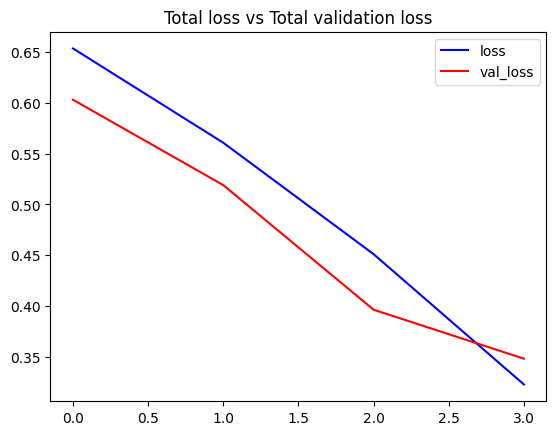

In [ ]:
plot_curve(history,'loss','val_loss',"Total loss vs Total validation loss")

In [ ]:
predictions = model.predict(x_test)

# Assuming predictions are in probability form and you need to convert them to binary labels
binary_predictions = (predictions > 0.5).astype('int32')

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, binary_predictions, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Precision: [0.86311239 0.87521664]
Recall: [0.94330709 0.72661871]
F1 Score: [0.90142965 0.79402516]


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming test_Y is one-hot encoded
conf_matrix = confusion_matrix(true_labels, predicted_labels)

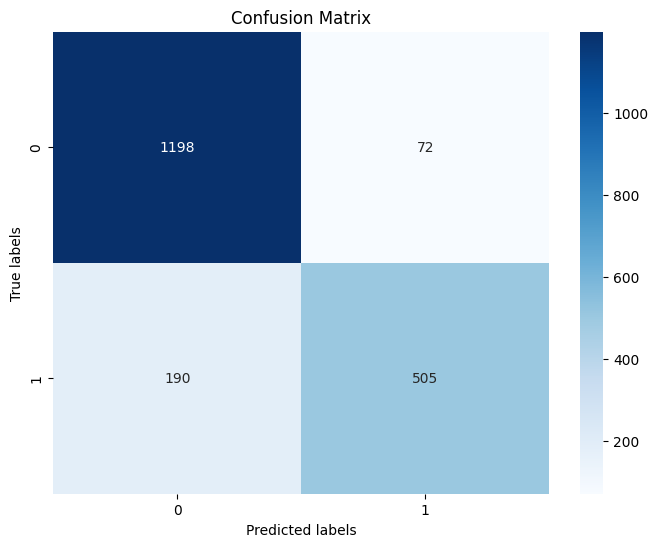

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model in .h5 format
model_path = '/content/drive/My Drive/60_model_bs_256_frame2.h5'
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/60_model_bs_256_frame2.h5
